## Forward Workflow

In [147]:
import sys
import os
neural_struct_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/'
sys.path.insert(0, neural_struct_dir)
# print(sys.executable)

from neural_structural_optimization import problems
from neural_structural_optimization import train
from neural_structural_optimization import models
from neural_structural_optimization import topo_api
import numpy as np
import matplotlib.pyplot as plt

problem_mbb = problems.mbb_beam(width=64, height=32, density=0.5)
args_mbb = topo_api.specified_task(problem_mbb)

/home/shushu/install/anaconda3/envs/neural-struct/bin/python


args_mbb defines the physical task of interests.

In [7]:
args_mbb

{'young': 1,
 'young_min': 1e-09,
 'poisson': 0.3,
 'g': 0,
 'volfrac': 0.5,
 'xmin': 0.001,
 'xmax': 1.0,
 'nelx': 64,
 'nely': 32,
 'mask': 1,
 'freedofs': array([   1,    3,    5, ..., 4286, 4287, 4288]),
 'fixdofs': array([   0,    2,    4,    6,    8,   10,   12,   14,   16,   18,   20,
          22,   24,   26,   28,   30,   32,   34,   36,   38,   40,   42,
          44,   46,   48,   50,   52,   54,   56,   58,   60,   62,   64,
        4289]),
 'forces': array([ 0., -1.,  0., ...,  0.,  0.,  0.]),
 'penal': 3.0,
 'filter_width': 2}

For better visulization, we demonstrated below a 8x4 mesh. A pixel is correspondent to an element in Finite Element Method. Each element has four nodes. And each node has two degree of freedoms (dof): one for displacement in x axis and the other for displacement in y axis. For example, dof1 means the displacement in y axis for node0 when using zero based numbering. The `fixdofs` in `args_mbb` means the corresponding node is pinned in that direction.

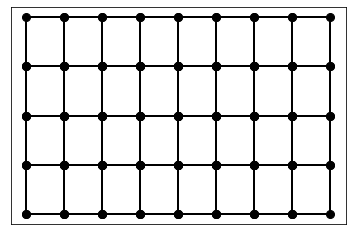

In [79]:
nelx = 8
nely = 4
nodes = np.zeros([(nely+1)*(nelx+1), 2])
for i in range(nelx+1):
    for j in range(nely+1):
#         print('{}: {} {}'.format(i*nely+j, i, j))
        nodes[i*(nely+1)+j] = [i, j]
ely, elx = np.meshgrid(range(nely), range(nelx)) 
ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)
n1 = (nely+1)*(elx+0) + (ely+0)
n2 = (nely+1)*(elx+1) + (ely+0)
n3 = (nely+1)*(elx+1) + (ely+1)
n4 = (nely+1)*(elx+0) + (ely+1)
nelem = nelx*nely
fig, ax = plt.subplots(subplot_kw={'xticks': [], 'yticks': []})
for elem in range(nelem):
    conn = [n1[elem], n2[elem], n3[elem], n4[elem],n1[elem]]
    ax.plot(nodes[conn,0], nodes[conn,1], 'o-k', linewidth=2, markersize=8)

In this problem, we want 50% of the grids can have material inside. And our goal is to decide the best way to put materials in order to obtain a resilient structure. Rather than optimizing densities on a grid, we instead optimized the parameters of a neural network which outputs those densities. More detailed information will be explained below.

In [148]:
cnn3_mbb = models.CNNModel(args=args_mbb, resizes=(1,2,1), conv_filters=(32,16,1))
# ds_cnn3_mbb = train.train_lbfgs(cnn3_mbb, 100)
cur_file_dir = os.path.join(neural_struct_dir, 'projects')
saved_dir = os.path.join(cur_file_dir, 'saved_models')
cnn3_mbb.load_weights(os.path.join(saved_dir, 'cnn3_mbb100'))

In [2]:
# cnn3_mbb.core_model.summary()

We use a CNN Model which has been trained for 100 steps to show the schema of the approach.

The default setting in the code:
- Input: 128 units
- a dense layer into 32 image channels
- 5 repetitions:
    - tanh nonlinearity
    - 2x bilinear resize (for the middle 3 layers)
    - global normalization by subtracting the mean and dividing by the standard deviation
    - a 2D convolution layer: The convolutional layers used 5x5 kernels and had 128,64,32,16,1 channels respectively.
    - a learned bias over all elements/channels
    
Here we only use 3 convolutional layers for simplification. The visulization of of the model is shown here--[CNN Model with 3 conv layers](https://gitmind.cn/app/flowchart/0ef2447387)


### Generate logits of picture

Firstly, CNN Model generates a picture of the structure (shown below). Each grid has an original density $x_e$. They are referred to as design variables.

In [117]:
logits0 = cnn3_mbb(None)  # cnn3_mbb.core_model(cnn3_mbb.z)

In [118]:
logits = np.squeeze(logits0)

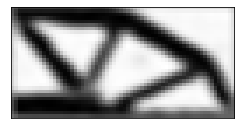

In [119]:
fig, ax = plt.subplots(figsize=(4,3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(logits, cmap='Greys')

### Transfer picture logits to physical logits

The CNN Model does not consider volume contraints (only 50% of the grids have materials) when generating the picture. So afterwards we apply volume constraints on that picture. This is implemented in `topo_physics.physical_density`. It gives us a sharper picture. The filtered densities $\tilde{x}_e$ are referred to as the physical densities. We always present the physical density field as the solution to the optimization problem.

Actually, the `topo_physics.physical_density` function can apply two kinds of operation:
- volume constraint
- cone filter
The meaning of volume constaint is straightforward. And what the cone filter does is calculating weighted average on the grid and its neighbors within a predefined radius. The further the neighboring grid locates, the smaller the weight factor is.

They are both activated by default.

In [93]:
from neural_structural_optimization import topo_physics

In [120]:
env = cnn3_mbb.env
args = env.args

In [95]:
phy_logits = topo_physics.physical_density(logits, env.args, volume_contraint=True, cone_filter = True)

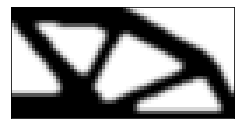

In [96]:
fig, ax = plt.subplots(figsize=(4,3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(phy_logits, cmap='Greys')

#### 1. Apply volume constaint

In [125]:
from neural_structural_optimization import autograd_lib
mask = np.broadcast_to(args['mask'], logits.shape) > 0
x_designed = topo_physics.sigmoid_with_constrained_mean(logits[mask], args['volfrac'])
x_flat = autograd_lib.scatter1d(x_designed, np.flatnonzero(mask), logits.size)
x = x_flat.reshape(logits.shape)

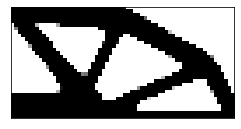

In [126]:
fig, ax = plt.subplots(figsize=(4,3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(x, cmap='Greys')

#### 2. Apply cone filter

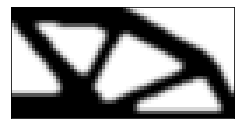

In [127]:
x = autograd_lib.cone_filter(x, args['filter_width'], args['mask'])
fig, ax = plt.subplots(figsize=(4,3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(phy_logits, cmap='Greys')

In [146]:
a = np.zeros([5,5])
a[1,1] = 1
# a[2,2] = 20
print(a)
b = autograd_lib.cone_filter(a,1.5)
print(b)

[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[0.03317615 0.15765048 0.02704855 0.         0.        ]
 [0.15765048 0.39030526 0.13010175 0.         0.        ]
 [0.02704855 0.13010175 0.02232193 0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


### Loss function

With the physical density field, we can calcluate the displacement of the structure undergoing the given forces and displacement constraints with finite element method. Then the loss function is defined as the compliance of the structure(the inverse of stiffness).

In [149]:
cnn3_mbb.loss(logits0)

<tf.Tensor: shape=(), dtype=float64, numpy=86.02795359899591>

In [99]:
topo_physics.objective(logits, env.ke, env.args, True, True)

86.0279477462498

#### 1. Calculate displacement

In [106]:
phy_logits = topo_physics.physical_density(logits, env.args, volume_contraint=True, cone_filter = True)
args = env.args
kwargs = dict(penal=args['penal'], e_min=args['young_min'], e_0=args['young'])
forces = topo_physics.calculate_forces(phy_logits, args)
u = topo_physics.displace(phy_logits, env.ke, forces, args['freedofs'], args['fixdofs'], **kwargs)
print(u)

[  0.         -86.02794775   0.         ...  -2.31585346 -26.79066526
   0.        ]


#### 2. Calculate loss function (ie. compliance)

In [129]:
topo_physics.compliance(phy_logits, u, env.ke, **kwargs)

86.0279477462498

## Train CNN model

In [151]:
# model = cnn3_mbb
# tvars = model.trainable_variables
# latent_size = 128
# filters = int(64/2*32/2*32)
# print('#filters: ', filters)
# print(tvars)

### Backward propogation

The backward pass is computed via automatic differentiation. Below is the code snippet from `train` module.

In [152]:
def value_and_grad(x):
    _set_variables(tvars, x)
    with tf.GradientTape() as t:
      t.watch(tvars)
      logits = model(None)
      loss = model.loss(logits)
    grads = t.gradient(loss, tvars)
    frames.append(logits.numpy().copy())
    losses.append(loss.numpy().copy())
    return float(loss.numpy()), _get_variables(grads).astype(np.float64)